# Сборный проект —2

## Описание проекта

Позади много уроков и заданий, и закрепить свои знания, как обычно, вы сможете в самостоятельном проекте. Это непростой проект, в котором от вас потребуется больше самостоятельности. Этапы работы описаны кратко, и вам понадобится декомпозировать задачи, то есть разделить их на более мелкие. Опирайтесь на знания об этапах анализа данных и машинного обучения из прошлых курсов.

Перейдём к задаче. HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.

Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 

Собирать данные такими опросниками не так легко: компания большая, и всех сотрудников надо сначала оповестить об опросе, а затем проследить, что все его прошли. 

У вас будет несколько задач. Первая — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 

Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.

Ваша вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

Теперь расскажем подробнее о задачах.

## Задача 1: предсказание уровня удовлетворённости сотрудника

Для этой задачи заказчик предоставил данные с признаками:
- `id` — уникальный идентификатор сотрудника;
- `dept` — отдел, в котором работает сотрудник;
- `level` — уровень занимаемой должности;
- `workload` — уровень загруженности сотрудника;
- `employment_years` — длительность работы в компании (в годах);
- `last_year_promo` — показывает, было ли повышение за последний год;
- `last_year_violations` — показывает, нарушал ли сотрудник трудовой договор за последний год;
- `supervisor_evaluation` — оценка качества работы сотрудника, которую дал руководитель;
- `salary` — ежемесячная зарплата сотрудника;
- `job_satisfaction_rate` — уровень удовлетворённости сотрудника работой в компании, целевой признак.

In [1]:
!pip install phik -q

In [191]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from phik.report import plot_correlation_matrix
from phik import report

# загружаем класс pipeline
from sklearn.pipeline import Pipeline

# загружаем классы для подготовки данных
from sklearn.preprocessing import (
    OneHotEncoder, 
    OrdinalEncoder, 
    LabelEncoder, 
    StandardScaler, 
    MinMaxScaler, 
    RobustScaler, 
    PolynomialFeatures
)
from sklearn.compose import ColumnTransformer

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем функцию для работы с метриками
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer

# импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# загружаем нужные модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from sklearn.feature_selection import SelectKBest, f_classif

## Шаг 1. Загрузка данных

In [3]:
train_job_satisfaction_rate = pd.read_csv('https://code.s3.yandex.net/datasets/train_job_satisfaction_rate.csv')
test_features = pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv')
test_target_job_satisfaction_rate = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_job_satisfaction_rate.csv')

In [4]:
def primary_information(df):
    print(f"Размерность: {df.shape}")
    display(df.info())
    display(df.head())

In [5]:
primary_information(train_job_satisfaction_rate)

Размерность: (4000, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


None

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [6]:
primary_information(test_features)

Размерность: (2000, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


None

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [7]:
primary_information(test_target_job_satisfaction_rate)

Размерность: (2000, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


None

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


### Промежуточный вывод
Было успешно выгружено три датасета:
- Тренировочная выборка
- Входные признаки тестовой выборки
- Целевой признак тестовой выборки

Первичный анализ показал следующее:
- Датасет тренировочной выборки имеет пропущенные значения:
    - `dept` - 6 позиций
    - `level` - 4 позиции
- Датасет входных признаков тестовой выборки имеет пропущенные значения:
    - `dept` - 2 позиции
    - `level` - 1 позиция
- Датасет целевого признака тестовой выборки пропущенных значений не имеет


## Шаг 2. Предобработка данных

Изучите данные и сделайте выводы. При необходимости выполните предобработку. Если есть пропуски, заполните их в пайплайне.

In [8]:
train_job_satisfaction_rate.isna().sum()

id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

In [9]:
test_features.isna().sum()

id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

In [10]:
col_names = {
    'dept': 'Отдел',
    'level': 'Уровень занимаемой должности',
    'workload': 'Уровень загруженности',
    'employment_years': 'Длительность работы',
    'last_year_promo': 'Наличие повышения',
    'last_year_violations': 'Наличие нарушений трудового договора',
    'supervisor_evaluation': 'оценка качества работы сотрудника', 
    'salary': 'Зарплата',
    'job_satisfaction_rate': 'Уровень удовлетворённости сотрудника'

}
ohe_columns = ['last_year_promo', 'last_year_violations']
ord_columns = ['dept', 'level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']

Создадим пайплайн для заполнения пропусков с помощью `SimpleImputer`:

In [11]:
ord_pipe = Pipeline(
    [
        ('simpleImputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ]
)

In [12]:
data_preprocessor = ColumnTransformer(
    [
        ('ord', ord_pipe, ord_columns),
    ], 
    remainder='passthrough'
) 

In [13]:
pd.DataFrame(data_preprocessor.fit_transform(train_job_satisfaction_rate), columns=train_job_satisfaction_rate.columns).isna().sum()

id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

Пайплайн со совей задачей справляется, идем дальше

Проверим датасеты на наличие дубликатов:

In [14]:
train_job_satisfaction_rate[train_job_satisfaction_rate.duplicated()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate


In [15]:
test_features[test_features.duplicated()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary


In [16]:
test_target_job_satisfaction_rate[test_target_job_satisfaction_rate.duplicated()]

,id,job_satisfaction_rate


Дубликаты отсутствуют. Проверим наличие неявных дубликатов

In [17]:
for category in ord_columns + ohe_columns:
    print(f"{col_names[category]} - {train_job_satisfaction_rate[category].unique()}")
    print(f"{col_names[category]} - {test_features[category].unique()}")

Отдел - ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
Отдел - ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
Уровень занимаемой должности - ['junior' 'middle' 'sinior' nan]
Уровень занимаемой должности - ['junior' 'middle' 'sinior' nan]
Уровень загруженности - ['medium' 'high' 'low']
Уровень загруженности - ['medium' 'low' 'high' ' ']
Наличие повышения - ['no' 'yes']
Наличие повышения - ['no' 'yes']
Наличие нарушений трудового договора - ['no' 'yes']
Наличие нарушений трудового договора - ['no' 'yes']


Неявные дубликаты отсутствуют

## Шаг 3. Исследовательский анализ данных

Объявим функции, необходимые для отображения графической информации

In [18]:
def show_boxbar_for_group(df, column, columns, cols):
    rows = ((len(columns) + cols - 1) // cols)
    fig, axs = plt.subplots(ncols=cols, nrows=rows, figsize=(18, 4 * rows))
    for i in range(len(columns)):
        sns.boxplot(x = columns[i], y = column, data = df, ax=axs[i // cols][i % cols])
        axs[i // cols][i % cols].set_xlabel(col_names[columns[i]])
        axs[i // cols][i % cols].set_ylabel('')
    fig.suptitle(col_names[column], fontsize=30)

In [19]:
def show_hist_for_group(df, column, columns, cols, main_title):
    rows = ((len(columns) + cols - 1) // cols)
    fig, axs = plt.subplots(ncols=cols, nrows=rows, figsize=(18, 4 * rows))
    for i in range(len(columns)):
        sns.histplot(x = columns[i], hue = column, data = df, multiple = "dodge", ax=axs[i // cols][i % cols])
    fig.suptitle(main_title, fontsize=30)

In [20]:
def show_pie(df, columns):
    fig, axes = plt.subplots(nrows=1, ncols=len(columns), sharey=True, figsize=(18, 6))
    if len(columns) == 1:
        (
            df[columns[0]].value_counts().plot.pie(autopct='%1.f%%', legend=False,
                wedgeprops = {"edgecolor" : "white", 
                              'linewidth': 2, 
                              'antialiased': True})
        )
        axes.title.set_text(columns[0])
    else:
        idx = 0
        for column in columns:    
            (
                df[column].value_counts().plot.pie(ax=axes[idx], autopct='%1.f%%', legend=False,
                    wedgeprops = {"edgecolor" : "white", 
                                  'linewidth': 2, 
                                  'antialiased': True})
            )
            axes[idx].title.set_text(col_names[columns[idx]])
            idx+=1

Построим ящики с усами количественных переменных по всем данным

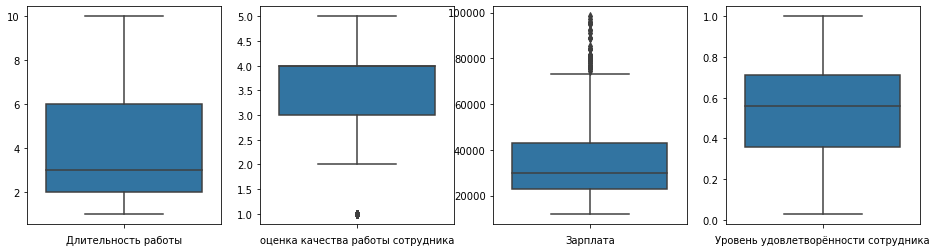

In [21]:
fig, axs = plt.subplots(ncols=4, nrows=1, figsize=(16, 4))
i = 0
for boxplot_col in num_columns:
    sns.boxplot(data = train_job_satisfaction_rate, y=boxplot_col, ax=axs[i])
    axs[i].set_xlabel(col_names[boxplot_col])
    axs[i].set_ylabel('')
    i += 1
fig.suptitle("", fontsize=30);

Построим ящики с усами количественных переменных в разрезе категориальных переменных

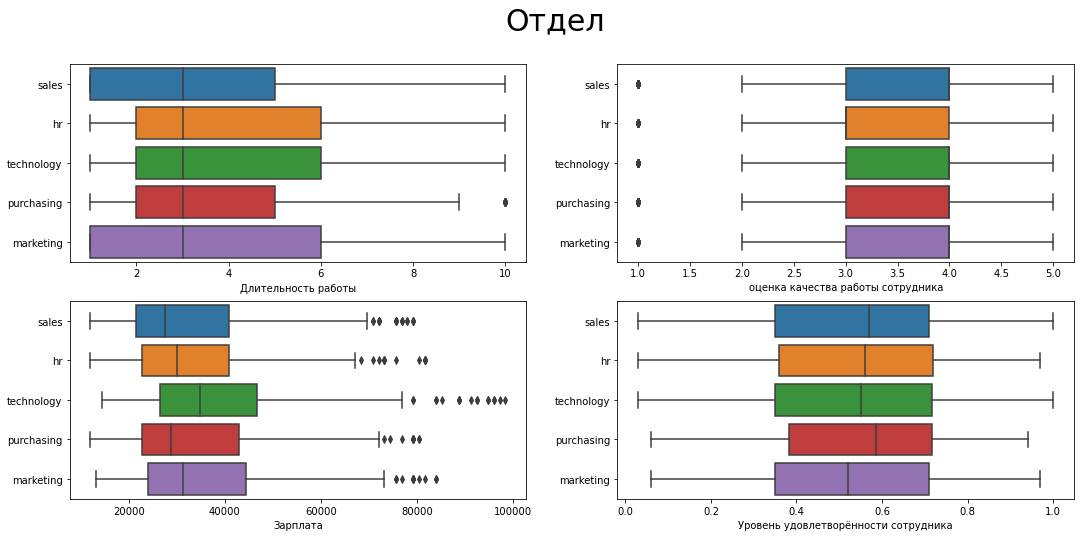

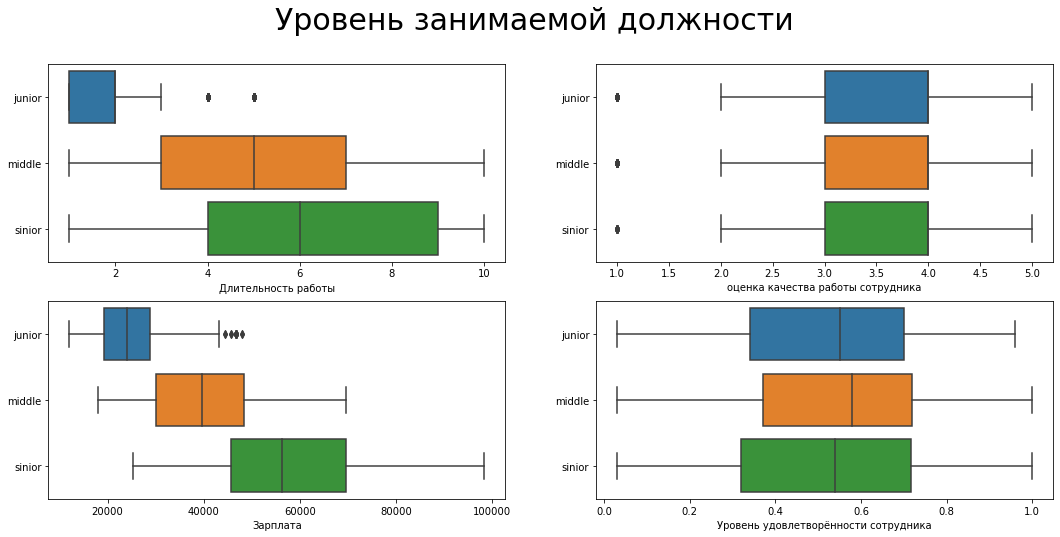

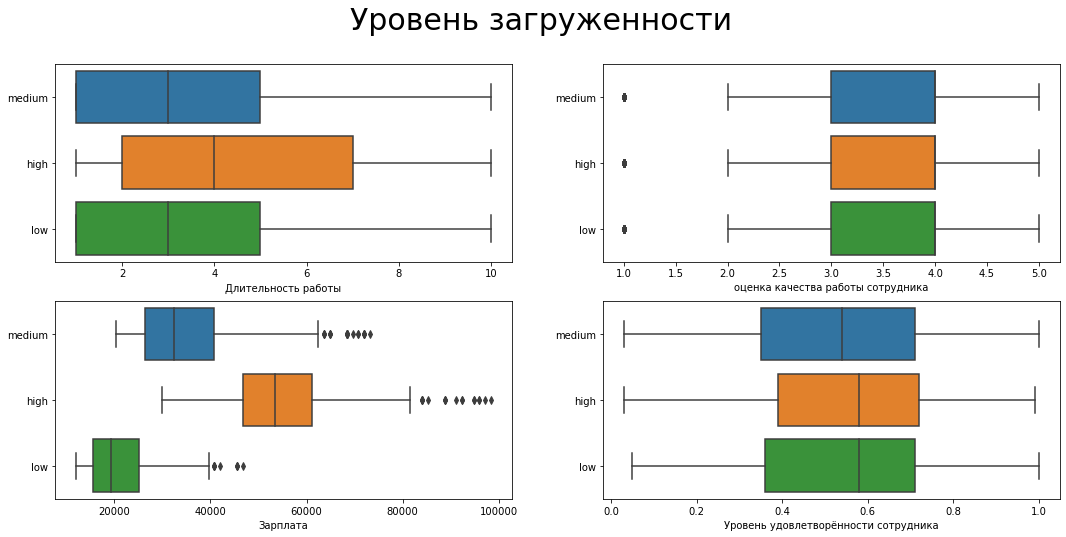

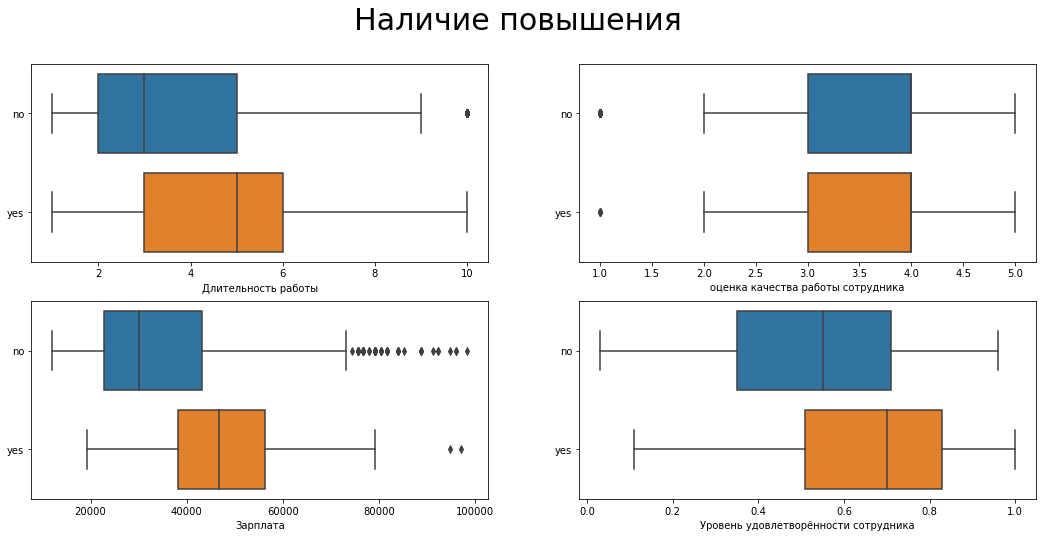

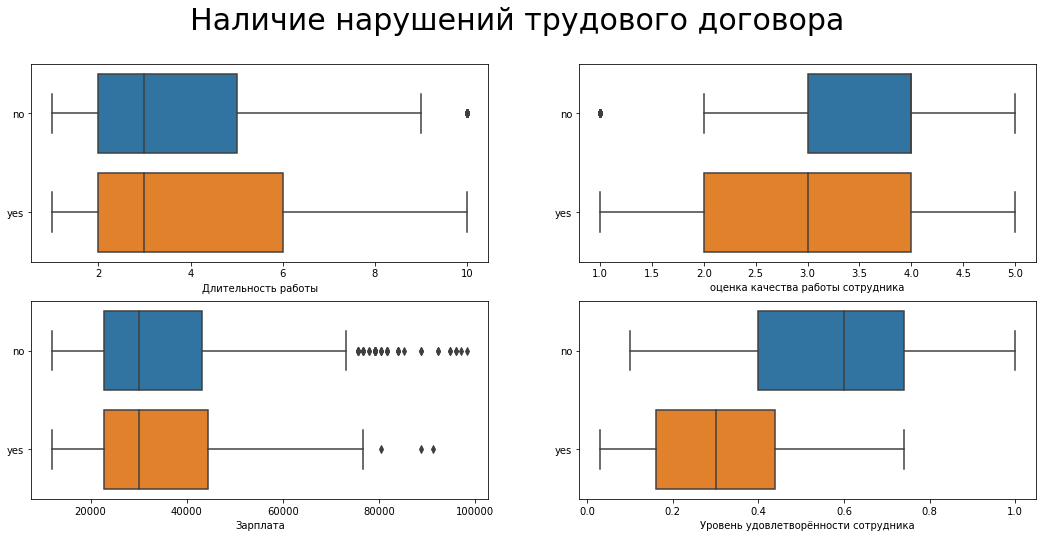

In [22]:
for category in ord_columns + ohe_columns:
    show_boxbar_for_group(
        train_job_satisfaction_rate, 
        category,
        num_columns, 
        2
    )

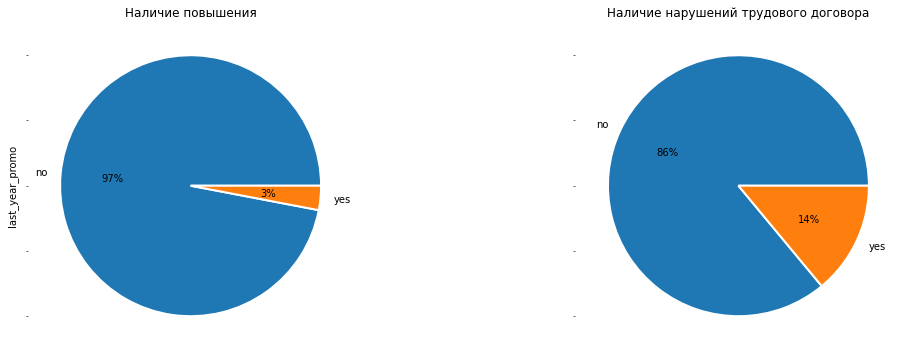

In [23]:
show_pie(
    train_job_satisfaction_rate, 
    ohe_columns
)

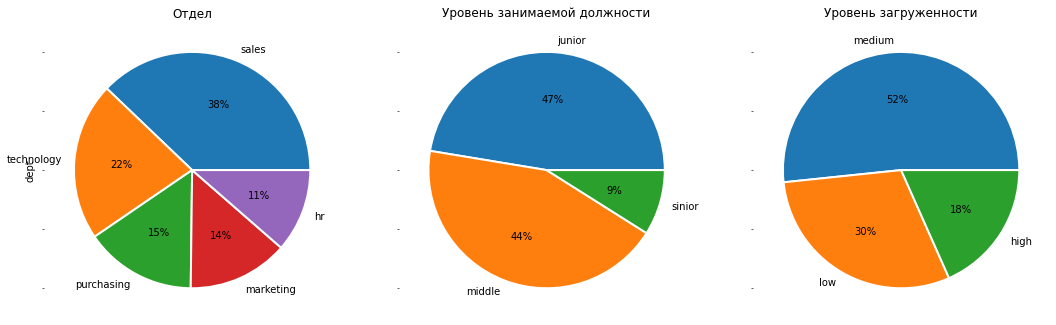

In [24]:
show_pie(
    train_job_satisfaction_rate, 
    ord_columns
)

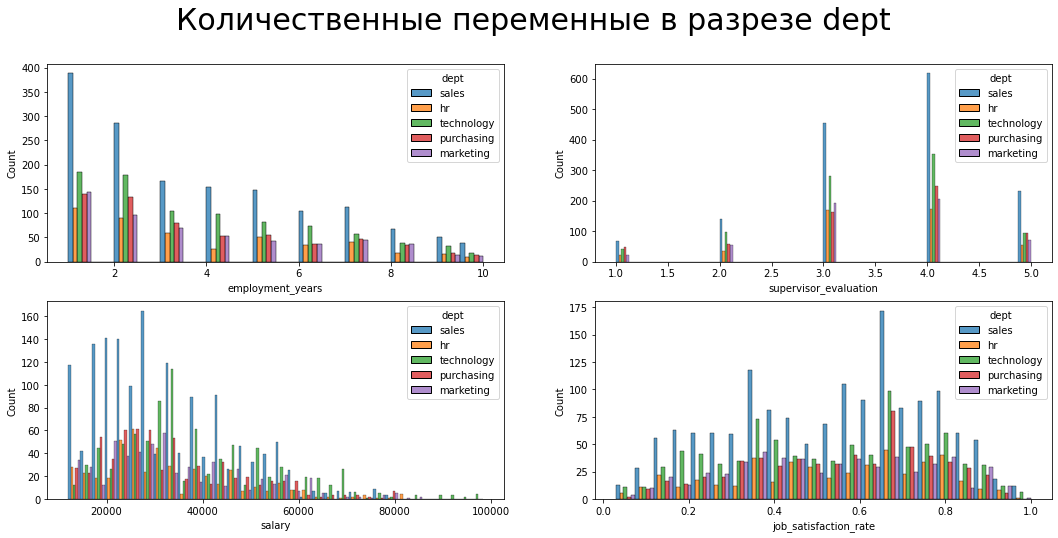

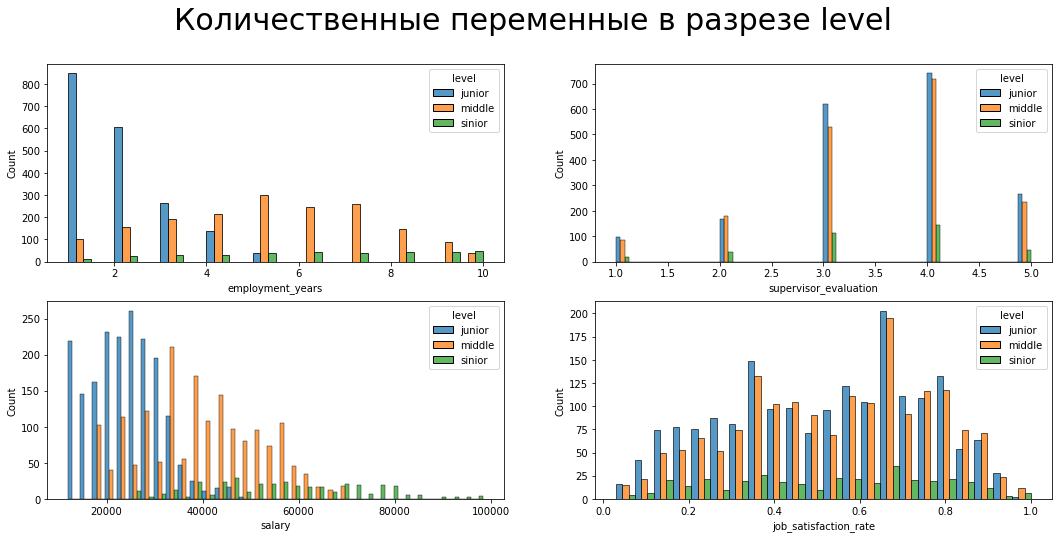

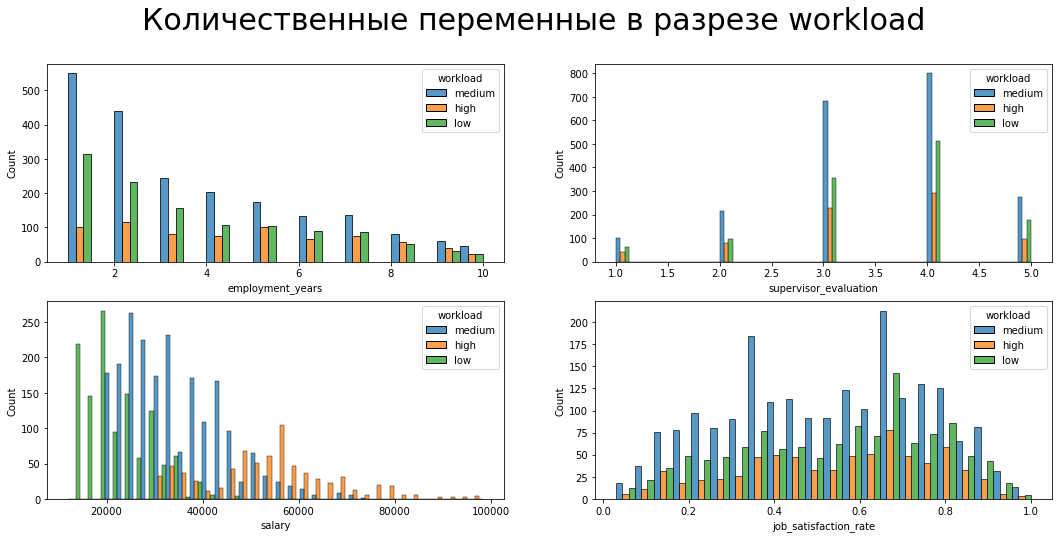

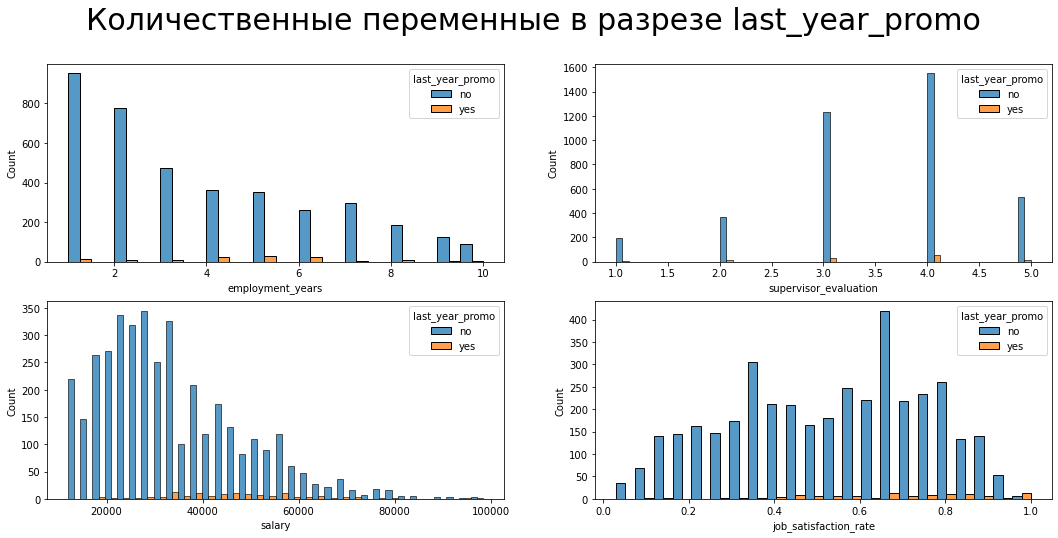

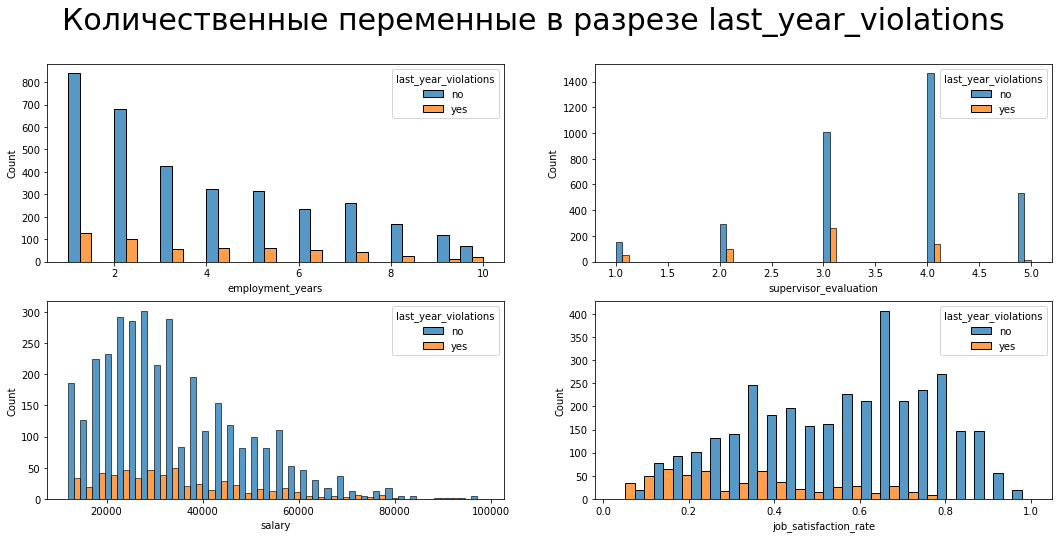

In [25]:
for category in ord_columns + ohe_columns:
    show_hist_for_group(
        train_job_satisfaction_rate, 
        category,
        num_columns, 
        2,
        f'Количественные переменные в разрезе {category}'
    )

interval columns not set, guessing: ['id', 'employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']


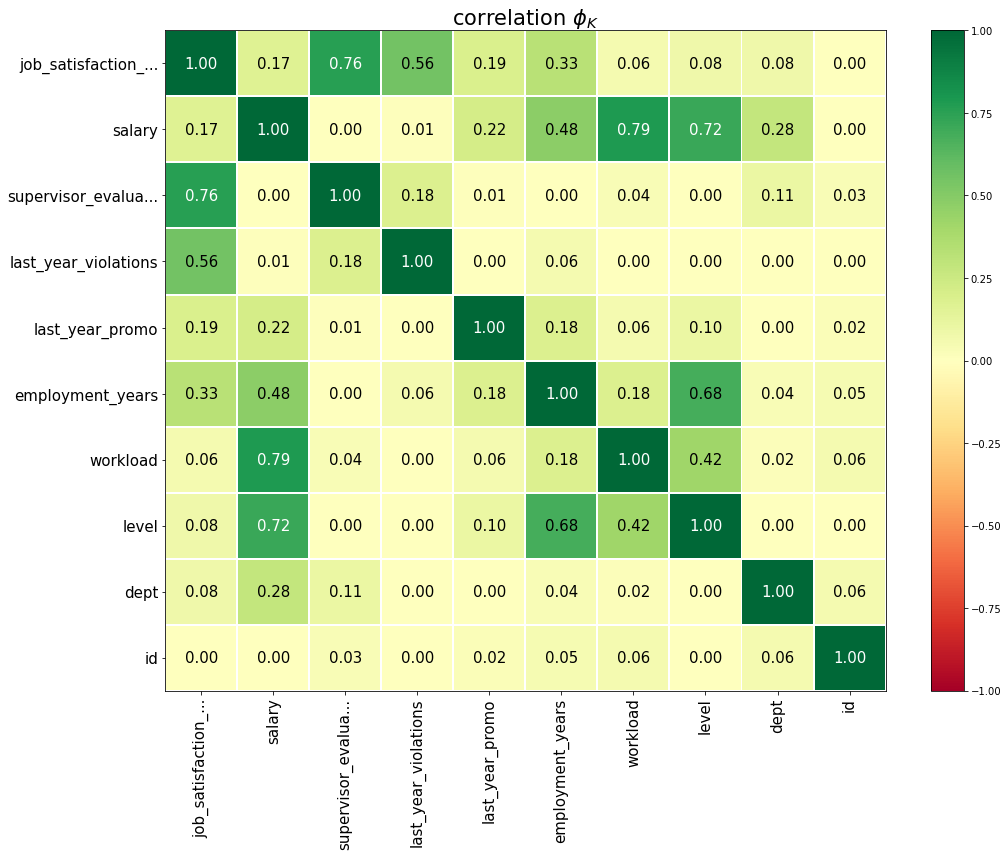

In [26]:
phik_overview = train_job_satisfaction_rate.phik_matrix()

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$",
    fontsize_factor=1.5,
    figsize=(15, 12)
);

Мультиколлинеарности не обнаружено

## Шаг 4. Подготовка данных

Подготовку признаков выполните в пайплайне, дополнив пайплайн шага предобработки. При кодировании учитывайте особенности признаков и моделей и используйте как минимум два кодировщика.

In [182]:
ohe_columns = ['last_year_promo', 'last_year_violations']
ord_columns = ['dept', 'level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary']

In [183]:
X_train, X_valid, y_train, y_valid = train_test_split(
    train_job_satisfaction_rate[ohe_columns+ord_columns+num_columns],
    train_job_satisfaction_rate['job_satisfaction_rate'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = train_job_satisfaction_rate['job_satisfaction_rate'])

X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((3000, 8), (1000, 8), (3000,), (1000,))

Создадим пайплайн предобрабочиков

In [224]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse=False))
    ]
)
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['sales', 'hr', 'technology', 'purchasing', 'marketing'],
                    ['junior', 'middle', 'sinior'],
                    ['low', 'medium', 'high'],
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns),
    ], 
    remainder='passthrough'
)

In [266]:
X_train_preprocessed = data_preprocessor.fit_transform(X_train)
X_valid_preprocessed = data_preprocessor.fit_transform(X_valid)

/home/iuser24/anaconda3/lib/python3.8/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)
/home/iuser24/anaconda3/lib/python3.8/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid thi

## Шаг 5. Обучение моделей

In [27]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

Для начала создадим метрику SMAPE:

In [180]:
def smape_scorer(y_true, y):
    numerator = abs(y_true-y)
    denominator = (abs(y_true)-abs(y))/2
    metric = 100 * (numerator / denominator).mean()
    return metric

In [227]:
smape_score = make_scorer(smape_scorer, greater_is_better=False)

In [234]:
lr_model = LinearRegression()
tree_model = DecisionTreeRegressor()
lr_model.fit(X_preprocessed, y_train)
tree_model.fit(X_preprocessed, y_train);

In [232]:
param_grid = {
    'max_depth': range(2, 15),
    'min_samples_split': range(2, 5),
    'min_samples_leaf': range(1, 5)
}

In [267]:
randomized_search = RandomizedSearchCV(
    tree_model, 
    param_grid, 
    cv=5,
    random_state=42,
    scoring=smape_score,
    n_jobs=-1
)
randomized_search.fit(X_train_preprocessed, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Лучшая модель и её параметры:

 DecisionTreeRegressor(max_depth=13, min_samples_leaf=3, min_samples_split=3)
Метрика лучшей модели на тренировочной выборке: 3.7568417499925864


In [ ]:
print(f"Метрика SMAPE на тестовой выборке: {smape_scorer(y_valid, y_test_pred)}")

In [258]:
X_test_preprocessed = data_preprocessor.transform(test_features[ohe_columns+ord_columns+num_columns])
y_test = test_target_job_satisfaction_rate['job_satisfaction_rate']

In [268]:
y_test_pred = lr_model.predict(X_valid_preprocessed)

Метрика SMAPE на тестовой выборке: 4.885096938874487


<AxesSubplot:xlabel='job_satisfaction_rate'>

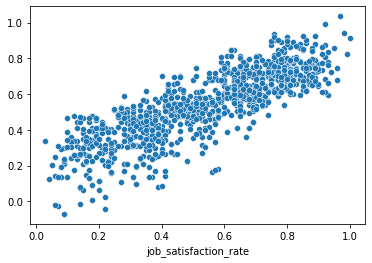

In [270]:
print(f"Метрика SMAPE на тестовой выборке: {smape_scorer(y_valid, y_test_pred)}")
sns.scatterplot(y_valid, y_test_pred)